# Reaction-Diffusion Problem Solutions


Here I will provide both the numerical and analytic solitions to the problems you gave me.

## Problem 1

First I will calculate a numerical solution. I decided to go with a simple implicit finite difference solution method, the Crank-Nicolson method. I figured this was a good choice as the diffusion equation is stiff so implicit methods can reduce the error from large timesteps. I'll start with the homogeneuos equation, then add in the reaction term.

The Crank-Nicolson method discretizes the diffusion equation into a finite differences in space and time. In particular, it uses a trapezoidal approximation to integrating from $t_n$ to $t_{n+1}$, which ends up looking like taking the average of $\frac{\partial^2 C}{\partial x^2}$ between $t_n$ and $t_{n+1}$. This results in a tridiagonal system of equations over the whole discretized spatial coordinate.

$$
\begin{align}
\frac{\partial C}{\partial t} &= D \frac{\partial^2 C}{\partial x^2}
\\[1em]
\frac{\Delta_+ C}{\Delta t} &= D \cdot \text{Avg} \left(\frac{\Delta^2 C}{\Delta x^2}\right)
\\[1em]
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= D\frac{1}{2}\left(\frac{C_{i-1}^n-2C_i^n+C_{i+1}^n}{\Delta x^2}+\frac{C_{i-1}^{n+1}-2C_i^{n+1}+C_{i+1}^{n+1}}{\Delta x^2}\right)
\end{align}
$$

With some rearranging, this gives a general formula for how to get $C_i^{n+1}$ for all positions $x_i$, given knowledge of $C_i^n$. Since the concentration is just 0 at the boundaries, it won't effect the rest of the substrate and we can just ignore it.

$$
A \bold{C}^{n+1} = B \bold{C}^n

\\[1em]

r = \frac{D \Delta t}{2 \Delta x^2}

\\[1em]

A = \begin{bmatrix}
    (1+2r) & -r & & & & \\
    -r & (1+2r) & -r & & & \\
      & -r & (1+2r) & -r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r & (1+2r) & -r \\
      & & & & -r & (1+2r)
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-2r) & r & & & & \\
    r & (1-2r) & r & & & \\
      & r & (1-2r) & r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r & (1-2r) & r \\
      & & & & r & (1-2r)
\end{bmatrix}
$$


From here, it's pretty straighforward (at least numerically) to add in the $kC$ reaction term: it just adjusts the concentration by $-\Delta t k C_i$ each timestep, at each point $x_i$. This is called an implicit/explicit (IMEX) method, because the spatial/laplacian term is determined implicitly while the reaction term is determined explicitly.

$$
A \bold{C}^{n+1} = B \bold{C}^n - \Delta t k \bold{C}^n
$$


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg as la


def CN(C0: callable, D, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propogation to find concentration profile over time. 
    Uses boundary condition C(0,0)=C(0,L)=0.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)
    r = (D*dt)/(2*dx**2)

    A_bands = np.zeros((3,nspace))
    A_bands[0,1:] = -r
    A_bands[1,:] = 1+2*r
    A_bands[2,:-1] = -r
    B = np.diag((1-2*r) * np.ones(nspace)) + np.diag(r*np.ones(nspace-1), k=+1)+np.diag(r*np.ones(nspace-1), k=-1)

    C = np.empty((ntime+1, nspace)) # (n,i)
    C[0,:] = C0(np.linspace(0, L, nspace))

    for n in range(ntime):
        b = B@C[n] - dt*k*C[n]
        b[0]=0
        b[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, b) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    return C


def analytic(C0: float, D, L, k, t, N=100, nspace=500):
    '''
    An analytic solution to compare results with.
    '''
    x = np.linspace(0, L, nspace)
    C = np.zeros_like(x)
    for n in range(1, N+1):
        bn = ((2.0*C0)/(n*np.pi))*(1 - (-1)**n)
        C += bn * np.sin((n*np.pi*x)/L) * np.exp(-(k + D*((n*np.pi)/L)**2)*t)
    return C


### Testing the numerical vs. Analytic Solution

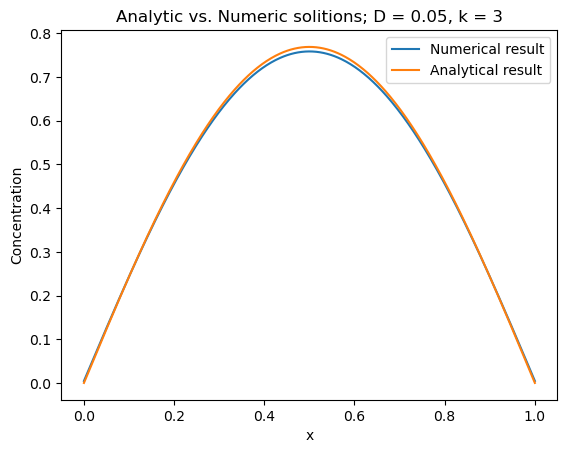

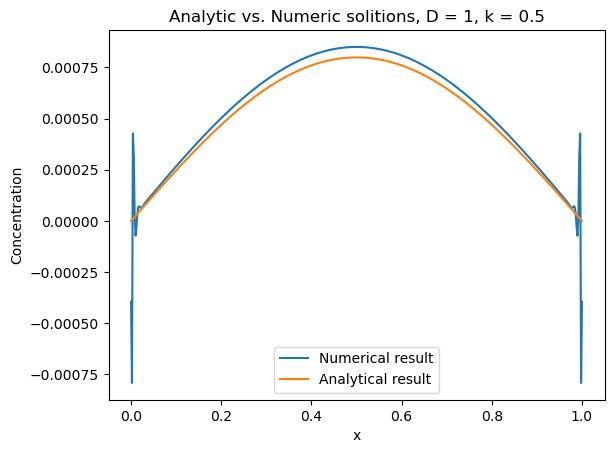

In [92]:
C0 = lambda x: 20
D = 0.05
L = 1
k = 3
tf = 1

C_num = CN(C0, D, L, k, tf)[-1]
C_analytic = analytic(C0(1), D, L, k, tf)

x = np.linspace(0, L, len(C_num))

plt.figure(1)
plt.plot(x, C_num, label='Numerical result')
plt.plot(x, C_analytic, label='Analytical result')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.title('Analytic vs. Numeric solitions; D = 0.05, k = 3')

plt.figure(2)
D = 1
k = 0.5
C_num = CN(C0, D, L, k, tf)[-1]
C_analytic = analytic(C0(1), D, L, k, tf)
plt.plot(x, C_num, label='Numerical result')
plt.plot(x, C_analytic, label='Analytical result')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.title('Analytic vs. Numeric solitions, D = 1, k = 0.5')

plt.show()

As you can see, the results are pretty accurate, but there's some weird stuff going on when D is large.

Below I included a more interesting initial condition.

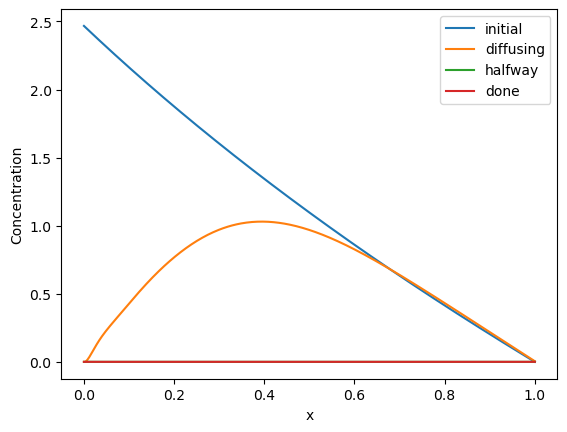

In [139]:
# Testing different C0

C0 = lambda x: np.arccos(x)**2  
D = 2
L = 1
k = 0
tf = 1

C = CN(C0, D, L, k, tf)

x = np.linspace(0, L, C.shape[1])
plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Space-Dependant Diffusion Coefficient

This makes the Crank-Nicolson method slightly more complicated, since you have to average the entire spatial operator $L=\frac{\partial}{\partial x}\left(D(x)\frac{\partial}{\partial x}\right)$ on C between $t_n$ and $t_{n+1}$, not just its second derivative. 
Now the equation becomes: 

$$
\begin{align}
\frac{\partial C}{\partial t} &= \frac{\partial}{\partial x} \left( D(x) \frac{\partial C}{\partial x} \right)
\\[1em]
\frac{\Delta_+ C}{\Delta t} &= \text{Avg}\left(\frac{1}{\Delta x} \left[ \frac{1}{2}\left(D_i+D_{i+1}\right) \frac{\Delta_+ C}{\Delta x}
                                                                  - \frac{1}{2}\left(D_{i-1}+D_i\right) \frac{\Delta_- C}{\Delta x} \right]\right)
\\[1em]
\alpha_i &= \frac{D_i+D_{i+1}}{2 \Delta x^2}
\\[1em]
\beta_i &=\frac{D_{i-1}+D_i}{2 \Delta x^2}
\\[1em]
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= \frac{1}{2} \left[ \alpha_i(C_{i+1}^{n+1}-C_i^{n+1})-\beta_i(C_i^{n+1}-C_{i-1}^{n+1}) + \alpha_i(C_{i+1}^n-C_i^n)-\beta_i(C_i^n-C_{i-1}^n)  \right]
\\[1em]
r &= \frac{\Delta t}{2}
\\[1em]
A_{i,i-1} &= -\,r\,\beta_i
\\[1em]
B_{i,i-1} &= \;\;r\,\beta_i
\\[1em]
A_{i,i}   &= 1 + r(\alpha_i+\beta_i)
\\[1em]
B_{i,i}   &= 1 - r(\alpha_i+\beta_i)
\\[1em]
A_{i,i+1} &= -\,r\,\alpha_i
\\[1em]
B_{i,i+1} &= \;\;r\,\alpha_i
\\[1em]

A \bold{C}^{n+1} &= B \bold{C}^n - \Delta t k \bold{C}^n

\end{align}

$$

In [155]:
def CN2(C0: callable, D: callable, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propogation to find concentration profile over time. 
    Uses boundary condition C(0,0)=C(0,L)=D(0)=D(L)=0.

    New: Now D can be variable in x.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient (function of x)
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)

    Di = np.linspace(0, L, nspace)
    Di[:] = D(Di) # Allows D to still work if it overwrites Di as a non-array, i.e. int/float

    # Initialize alpha_i's, beta_i's - formulas in md above
    alpha = np.zeros_like(Di)
    alpha[:-1] = (Di[:-1]+Di[1:])/(2*dx**2)
    beta = alpha.copy()
    r = dt/2

    # Sets up matrix of A's (off)diagonals to be solved by scipy solve_banded.
    A_bands = np.zeros((3,nspace))
    A_bands[0,1:] = -r*alpha[:-1]
    A_bands[1,:] = 1+r*(alpha+beta)
    A_bands[2,:-1] = -r*beta[:-1]

    B = np.diag(1-r*(alpha+beta)) + np.diag(r*alpha[:-1], k=+1)+np.diag(r*beta[:-1], k=-1)

    C = np.empty((ntime+1, nspace)) # (n,i)
    C[0,:] = C0(np.linspace(0, L, nspace))

    for n in range(ntime):
        b = B@C[n] - dt*k*C[n]
        b[0]=0
        b[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, b) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    return C

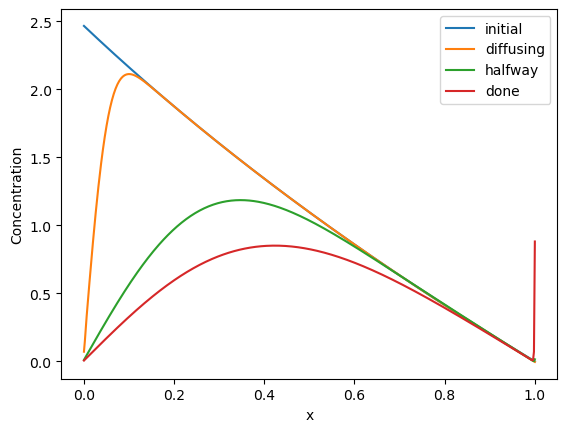

In [160]:
# Testing different C0

C0 = lambda x: np.arccos(x)**2  
D = lambda x: .05
L = 1
k = 0.05
tf = 1

C = CN2(C0, D, L, k, tf)

x = np.linspace(0, L, C.shape[1])
plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Coupled Species with Boundary Influx

This system of equations takes the form: 

$$
\begin{align}
A \bold{C_A}^{n+1} &= B \bold{C_A}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\\[1em]
A \bold{C_B}^{n+1} &= B \bold{C_B}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\end{align}
$$

Here I'm using $\bold{C_A}$ To denote species A and $\bold{C_B}$ to denote species B because I'm already using $A$ and $B$ for the LHS and RHS matrices defined previously. $\odot$ is denoting component multiplication.

Because of the $\frac{\partial C_A}{\partial x} (L,t)=0$ boundary condition, $\frac{\partial^2 C_A}{\partial x^2}=0$ so the concentration of B cannot change at this end.


In [178]:
def CN3(CA0: callable, CB0: callable, CB_surf, DA, DB, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propogation to find concentration profile of both species A and B over time. 
    Uses boundary condition C(0,0)=C(0,L); B(0,t)=B_surf, db/dx|(L,t)=0

    CA0: Function that represents the concentration profile at t=0.
    CB0: Same for CB
    CB_surf: CB fixed value at boundary x=0
    D: diffusion coefficient 
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)
    rA = (DA*dt)/(2*dx**2)
    rB = (DB*dt)/(2*dx**2)

    A_bands_A = np.zeros((3,nspace))
    A_bands_A[0,1:] = -rA
    A_bands_A[1,:] = 1+2*rA
    A_bands_A[2,:-1] = -rA

    A_bands_B = np.zeros((3,nspace))
    A_bands_B[0,1:] = -rB
    A_bands_B[1,:] = 1+2*rB
    A_bands_B[2,:-1] = -rB
    # Neumann boundary
    A_bands_B[0,-1] = 0      # upper diag
    A_bands_B[1,-1] = 1      # main diag
    A_bands_B[2,-2] = -1     # lower diag



    B_A = np.diag((1-2*rA) * np.ones(nspace)) + np.diag(rA*np.ones(nspace-1), k=+1)+np.diag(rA*np.ones(nspace-1), k=-1)
    B_B = np.diag((1-2*rB) * np.ones(nspace)) + np.diag(rB*np.ones(nspace-1), k=+1)+np.diag(rB*np.ones(nspace-1), k=-1)

    CA = np.zeros((ntime+1, nspace)) # (n,i)
    CB = np.zeros((ntime+1, nspace))

    CA[0,:] = CA0(np.linspace(0, L, nspace))
    CB[0,:] = CB0(np.linspace(0, L, nspace))

    for n in range(ntime):
        # Initialize RHS
        RHS_A = B_A@CA[n] - dt*k*CA[n]*CB[n]
        RHS_B = B_B@CB[n] - dt*k*CA[n]*CB[n]
        # Enforce Dirichlet/Neumann boundary
        RHS_A[0]=0
        RHS_A[-1]=0
        RHS_B[0]=CB_surf
        RHS_B[-1]=0
        # Solve
        CA[n+1,:]=la.solve_banded((1,1), A_bands_A, RHS_A)
        CB[n+1,:]=la.solve_banded((1,1), A_bands_B, RHS_B) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.
        # Enforce Dirichlet
        CA[n+1,0]  = 0
        CA[n+1,-1] = 0
        CB[n+1,0]  = CB_surf

    return CA, CB

In [ ]:
CA0 = lambda x: 0.2
CB0 = lambda x: 0.1
CB_surf = 0.1
DA = 0.2
DB = 0.2
L = 0.1
k = 0        # reaction off
tf = 1.0

CA, CB = CN3(CA0, CB0, CB_surf, DA, DB, L, k, tf)

x = np.linspace(0, L, CA.shape[1])

plt.plot(x, CA[0], marker='s', label='A: initial')
plt.plot(x, CA[10], marker='s', label = 'A: diffusing')
plt.plot(x, CA[250], marker='s', label = 'A: halfway')
plt.plot(x, CA[-1], marker='s', label='A: done')

plt.plot(x, CB[0], marker='^', label='A: initial')
plt.plot(x, CB[10], marker='^', label = 'A: diffusing')
plt.plot(x, CB[250], marker='^', label = 'A: halfway')
plt.plot(x, CB[-1], marker='^', label='A: done')

plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_8664\2715995820.py:47: RuntimeWarning: overflow encountered in multiply
  RHS_A = B_A@CA[n] - dt*k*CA[n]*CB[n]
C:\Users\willi\AppData\Local\Temp\ipykernel_8664\2715995820.py:48: RuntimeWarning: overflow encountered in multiply
  RHS_B = B_B@CB[n] - dt*k*CA[n]*CB[n]


ValueError: array must not contain infs or NaNs

In [189]:
# Use small grid for quick test
CA0 = lambda x: 0.2
CB0 = lambda x: 0.1
CB_surf = 0.1
DA = 0.2
DB = 0.2
L = 0.1
k = 0.0        # reaction off
tf = 1.0

# call with small grid
CA, CB = CN3(CA0, CB0, CB_surf, DA, DB, L, k, tf, nspace=50, ntime=50)

print("Done. shapes:", CA.shape, CB.shape)
print("CA[0] max/min:", CA[0].max(), CA[0].min())
print("CA[-1] max/min:", CA[-1].max(), CA[-1].min())
print("CB[0] max/min:", CB[0].max(), CB[0].min())
print("CB[-1] max/min:", CB[-1].min(), CB[-1].max())


Done. shapes: (51, 50) (51, 50)
CA[0] max/min: 0.2 0.2
CA[-1] max/min: 0.0 -132650632152.5962
CB[0] max/min: 0.1 0.1
CB[-1] max/min: 0.1 748148268418.6948
